# Predicting Median House Values
Using out of box machine learning methods, we evaluate the performance using root mean squared error after transformation. The data consists of housing information for districts in California.

# Data Extraction
Extract the data using a helper function.

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_tgz)
    housing_tgz.close()

Initial exploratory analsis and summary statistics of the dataset.

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Exploratory Analysis
Look for missing values, summary statistics and densities to identify possible options for feature selection.

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


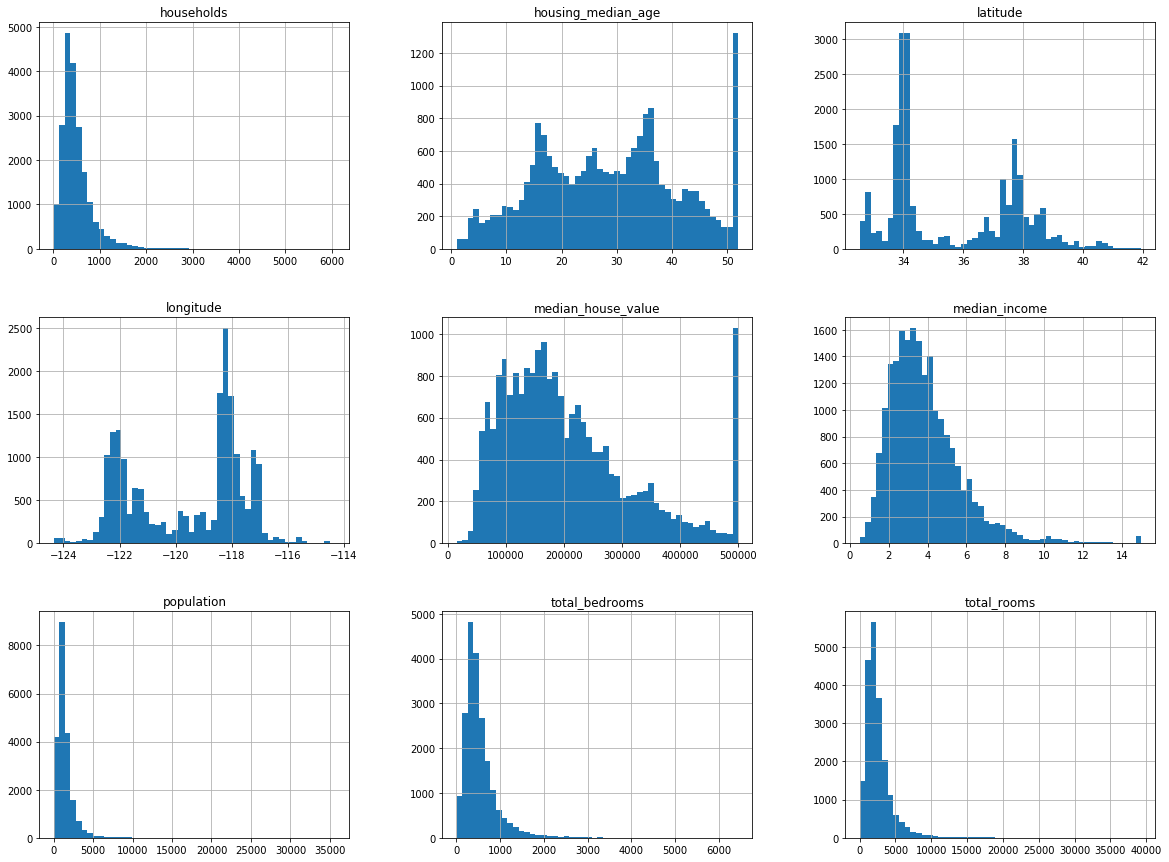

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

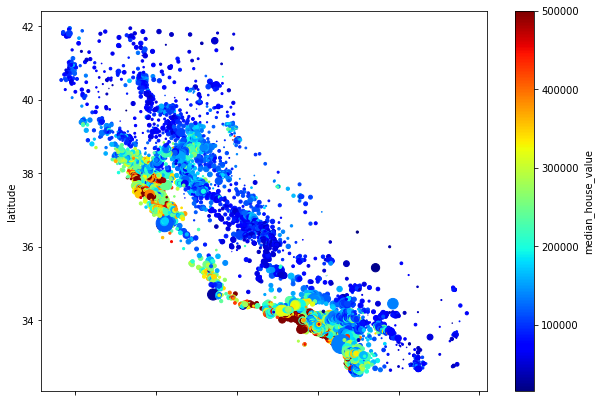

In [9]:
plt.figure(figsize=(15,10))
housing.plot(kind="scatter",
            x ="longitude",
            y ="latitude",
            c = "median_house_value",
            s = housing["population"]/1e2,
            cmap=plt.get_cmap("jet"),
            colorbar=True,
            figsize=(10,7))

plt.show()

# Data Preparation
Try a variety of methods to split the data. Introduce new features for bedrooms, standard scaling for the numerical columns and encoding for the categorical variables.

Attempt to define a function to split the data into train and test based on a test ratio. Numpy's random permutation is used to shuffle this.

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print('Train:', len(train_set), 'Test:', len(test_set))

Train: 16512 Test: 4128


Second attempt to produce random train and test sets that are deterministic, by creating a hash on an id column. The last byte of the hash will be equally distributed between 0 and 256. Taking the first 50 will make roughly a 20% test set.

In [12]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5): 
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]
    

housing_with_id = housing.copy()
housing_with_id["id"] = housing_with_id["longitude"] * 1000 + housing_with_id["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id,0.2, "id")


Use scikit-learn train_test_split method to do the splitting.

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42) 

Alternatively, opt for the stratified splitting. Median income seen as an important attribute so equal representation in both the train and test set is required. We first categorise the incomes into discretised bands.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
for train_index, test_index in sss.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Check if the stratification worked.

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64


3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

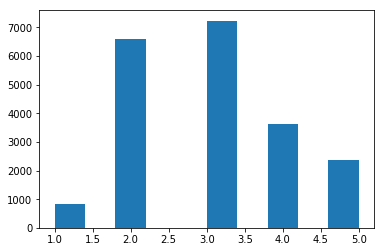

In [15]:
plt.hist(housing["income_cat"])
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1, inplace=True)

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [18]:
strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


Split the dataset into the various column types for tailoring the transformations.

In [19]:
numerics = ['int16','int32','int64','float16','float32','float64']
housing_num = housing.select_dtypes(include=numerics)
housing_cat = housing.select_dtypes(exclude=numerics)

Impute missing values with the median.

In [20]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imputed_housing = imp.fit_transform(housing_num)

Scale the features using standard scaling afterwards.

In [21]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
scaled_housing = scaling.fit_transform(imputed_housing)
scaled_housing

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

Create dummy variables for category in the non-numerical columns.

In [22]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

enc = OneHotEncoder()
housing_cat_encoded, housing_categories = housing["ocean_proximity"].factorize()
housing_cat_reshaped = housing_cat_encoded.reshape(-1,1)
housing_cat_1hot = enc.fit_transform(housing_cat_reshaped)

In [23]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

Helper class to select only certain types of columns so that we can apply the same transformations on them.

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnTypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols = cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.cols].values

Ratios per household represent the number of rooms much better than the total as a whole. 

In [2]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Pipelines allow you to chain a bunch of transformations together in one location. Much better than running each of them individually as you can retain the original state of the data much more easily.

In [5]:
from sklearn.pipeline import Pipeline

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline(steps = [
                           ('Select', ColumnTypeSelector(num_attribs)),
                           ('Imputer', Imputer(strategy="median")),
                           ('Combined Attributes', CombinedAttributesAdder()),
                           ('Scaler', StandardScaler()),
                       ])
                           
cat_pipeline = Pipeline(steps = [
                           ('Select', ColumnTypeSelector(cat_attribs)),
                           ('Encode', CategoricalEncoder(encoding='onehot-dense')),
                       ])

NameError: name 'housing_num' is not defined

Feature unions help when you're applying transformations to different feature types by concatenating the results together.

In [4]:
from sklearn.pipeline import FeatureUnion

combined_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline' , num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

NameError: name 'num_pipeline' is not defined

In [28]:
housing_prepared = combined_pipeline.fit_transform(housing)

# Training
Using linear regression, decision trees and finally regression forests, we attempt to predict the median house value using the training data. 

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
predictions = lin_reg.predict(housing_prepared)

In [30]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(predictions,housing_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

Too high error rate when considering the range of prices actually available.

In [31]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
tree_predict = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(tree_predict, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This is definitely overfitting, let's try mix up the training set using cross validation. Negative scoring used as minimising error is the same as maximizing the negative value of the error.

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
trees_rmse_scores = np.sqrt(-scores)

Display performance of each fold. Actually worse than the linear regressor.

In [33]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(trees_rmse_scores)

Scores: [ 69403.0764667   66957.85088367  70317.59940775  70059.57282509
  70045.73301714  72708.04096021  72312.01772186  71509.20132442
  75972.19379458  68906.49135767]
Mean: 70819.1777759
Standard Deviation: 2341.50457561


Try cross validation on the linear regression model. Turn's out this method is better on the data.

In [34]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse = np.sqrt(-lin_scores)

display_scores(lin_rmse)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard Deviation: 2731.6740018


Finally try the basic forest regressor ensemble method and evaluate the performance. This is much better than the other two models.

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse = np.sqrt(-forest_scores)
display_scores(forest_rmse)

Scores: [ 52658.27211192  49863.12710741  52406.33362085  55178.09298466
  53219.40153597  56892.45525392  51390.4866728   51618.1437911
  55913.73684343  53974.99190454]
Mean: 53311.5041827
Standard Deviation: 2079.00952456


Try optimise this model using an array of parameters. GridSearchCV lets you try out all possible combinations of parameters to create multiple models. Fit all of the models on the data.

The best model can be called directly using the best_params_ method.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

We can see the performance of the various choices of parameters available. The above parameters can be seen to have the lowest average error.

In [37]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64221.7919991 {'max_features': 2, 'n_estimators': 3}
55711.6330039 {'max_features': 2, 'n_estimators': 10}
53084.0914792 {'max_features': 2, 'n_estimators': 30}
60847.6824782 {'max_features': 4, 'n_estimators': 3}
52425.415519 {'max_features': 4, 'n_estimators': 10}
50632.1871379 {'max_features': 4, 'n_estimators': 30}
59101.9434917 {'max_features': 6, 'n_estimators': 3}
52356.1005936 {'max_features': 6, 'n_estimators': 10}
50017.7188957 {'max_features': 6, 'n_estimators': 30}
59540.6172295 {'max_features': 8, 'n_estimators': 3}
52419.4251215 {'max_features': 8, 'n_estimators': 10}
50160.0590744 {'max_features': 8, 'n_estimators': 30}
63070.1894562 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54668.3230097 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60824.4638718 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52184.6132482 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59256.5959314 {'bootstrap': False, 'max_features': 4, 'n_estima

Feature importance can be extracted from the best model to give insights into strong indicators of price. These need the field names to be added alongside it.

In [38]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.49272882e-02,   6.46080476e-02,   4.05253387e-02,
         1.93094280e-02,   1.65070721e-02,   1.90280175e-02,
         1.58442877e-02,   3.50576369e-01,   5.24915016e-02,
         1.03859569e-01,   6.25657730e-02,   7.89696939e-03,
         1.64071028e-01,   1.25031515e-04,   3.17369107e-03,
         4.49058716e-03])

Pair each importance with their respective column.

In [39]:
extra_attribs = ["rooms_per_household","pop_per_hhold","bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["Encode"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35057636897427613, 'median_income'),
 (0.16407102791615868, 'INLAND'),
 (0.1038595694890871, 'pop_per_hhold'),
 (0.074927288241782866, 'longitude'),
 (0.064608047622842807, 'latitude'),
 (0.062565772951740428, 'bedrooms_per_room'),
 (0.052491501645841036, 'rooms_per_household'),
 (0.040525338733268398, 'housing_median_age'),
 (0.019309428012318022, 'total_rooms'),
 (0.019028017511647247, 'population'),
 (0.016507072120198061, 'total_bedrooms'),
 (0.015844287651337316, 'households'),
 (0.0078969693873462889, '<1H OCEAN'),
 (0.004490587155293828, 'NEAR OCEAN'),
 (0.0031736910719653874, 'NEAR BAY'),
 (0.00012503151489644295, 'ISLAND')]

Finally we can evaluate the best model on the test set which we set aside earlier.

In [40]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = combined_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

48099.948397158332

Try the support vector machine instead, changing the kernel, C, and gamma parameters. Pick the best combination.

In [41]:
# from sklearn.svm import SVR

# support_vector = SVR()

# param_grid = [
#         {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000.]},
#         {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.],
#          'gamma': [0.01, 0.03]},
#     ]

# svm_reg = SVR()
# grid_search_sv = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)

# grid_search_sv.fit(housing_prepared, housing_labels)
# grid_search_sv.best_params_

Print the results of each set of parameters.

In [42]:
# cvres_svm = grid_search_sv.cv_results_

# for mean_score, params in zip(cvres_svm["mean_test_score"], cvres_svm["params"]):
#     print("mean_score: ", np.sqrt(-mean_score), params )

Now try using randomised search cross validation. This will allow us to check for a much larger space of parameters and doesn't rely on our intuition.

In [43]:
# from sklearn.model_selection import RandomizedSearchCV
# from random import randint 
# from scipy.stats import expon, reciprocal

# param_dist = {'kernel': ['linear','rbf'],
#               'C': reciprocal(20,2000),
#               'gamma': expon(1.0)}
     

# random_search = RandomizedSearchCV(support_vector, param_distributions=param_dist, cv=5, scoring="neg_mean_squared_error", n_jobs=4)
# random_search.fit(housing_prepared, housing_labels)


In [44]:
# cross_val_svm = random_search.cv_results_
# for mean_score, params in zip(cross_val_svm["mean_test_score"], cross_val_svm["params"]):
#     print(np.sqrt(-mean_score), params)

NameError: name 'random_search' is not defined

Using the importances learned from the decision tree model, we create a transformer that will pick out the top features by importance. List of tuples for the importances and the number of features to pick are required.

In [45]:
extra_attribs = ["rooms_per_household","pop_per_hhold","bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["Encode"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

feature_ranks = list(zip(attributes, feature_importances))

Transformer to select the features based on a number and the supplied importances.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k, feature_importances):
        self.k = k
        self.feature_importances = feature_importances
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, k)
        return self
    
    def transform(self, X, y=None):
        return X[:,self.feature_indices_]

New pipeline to incorporate the feature selection. k is the number of features we want to keep.

In [47]:
k = 5

new_pipeline = Pipeline(steps=[
    ('combined_pipeline', combined_pipeline),
    ('important_features', TopFeatureSelector(k, feature_importances)),
    ('random forest', RandomForestRegressor()),
])

new_pipeline.fit(housing, housing_labels)
predictions = new_pipeline.predict(housing)
mse = mean_squared_error(predictions, housing_labels)
rmse = np.sqrt(mse)
rmse

22092.156942568432

In [ ]:
grid_search.best_params_

In [ ]:
pipeline_params = {'important_features__k' : [1,2,3,4,5]}

automatic_search = GridSearchCV(new_pipeline, param_grid = pipeline_params, scoring = "neg_mean_squared_error", cv = 10, n_jobs=4) 

automatic_search.fit(housing, housing_labels)
cross_value_search = automatic_search.cv_results_